Generating synthetic data and training model...
Creating visualizations...


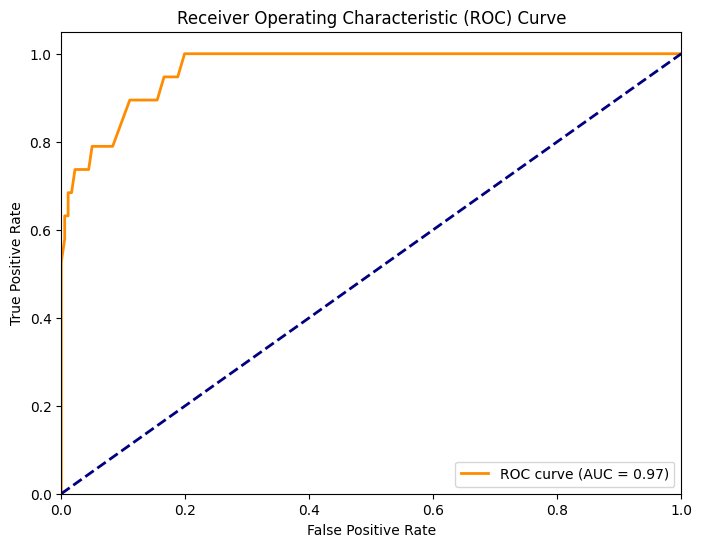

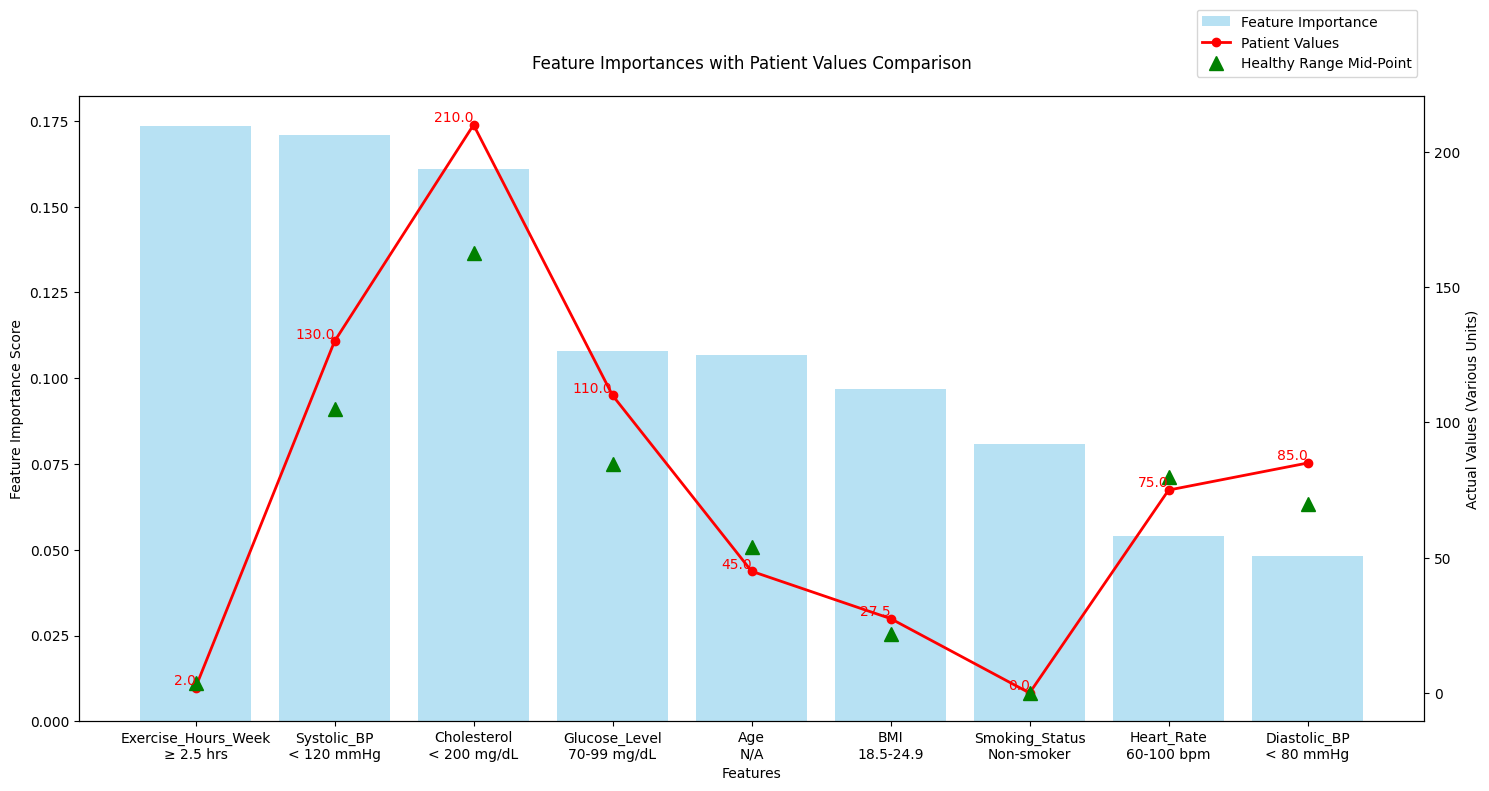

Generating report...
Report generated successfully: health_risk_reports/health_risk_report_20250111_140157.txt

Report Contents:
HEALTH RISK ANALYSIS REPORT
Generated on: 2025-01-11 14:02:02

1. MODEL PERFORMANCE METRICS
--------------------------------------------------------------------------------
Accuracy Score: 0.960

Confusion Matrix:
[[180   1]
 [  7  12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       181
           1       0.92      0.63      0.75        19

    accuracy                           0.96       200
   macro avg       0.94      0.81      0.86       200
weighted avg       0.96      0.96      0.96       200


2. PATIENT RISK ANALYSIS
--------------------------------------------------------------------------------
HEALTH RISK ASSESSMENT SUMMARY

Overall Risk Assessment:
📗 LOW RISK (Good health status)

Risk Probability: 1.0%

⚠️ Factors Requiring Monitoring:
- Exercise_Hours_Week: 2.0 (2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import joblib
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

class HealthRiskPredictor:
    def __init__(self):
        self.pipeline = None
        self.feature_names = None
        self.healthy_ranges = {
            'Age': {'min': 18, 'max': 90, 'optimal': 'N/A'},
            'Heart_Rate': {'min': 60, 'max': 100, 'optimal': '60-100 bpm'},
            'Systolic_BP': {'min': 90, 'max': 120, 'optimal': '< 120 mmHg'},
            'Diastolic_BP': {'min': 60, 'max': 80, 'optimal': '< 80 mmHg'},
            'Glucose_Level': {'min': 70, 'max': 99, 'optimal': '70-99 mg/dL'},
            'BMI': {'min': 18.5, 'max': 24.9, 'optimal': '18.5-24.9'},
            'Cholesterol': {'min': 125, 'max': 200, 'optimal': '< 200 mg/dL'},
            'Exercise_Hours_Week': {'min': 2.5, 'max': 5, 'optimal': '≥ 2.5 hrs'},
            'Smoking_Status': {'min': 0, 'max': 0, 'optimal': 'Non-smoker'}
        }

    def generate_synthetic_data(self, n_samples=1000):
        """Generate synthetic health data"""
        np.random.seed(42)

        data = {
            'Age': np.random.normal(50, 15, n_samples).clip(18, 90),
            'Heart_Rate': np.random.normal(75, 12, n_samples).clip(45, 120),
            'Systolic_BP': np.random.normal(120, 15, n_samples).clip(80, 180),
            'Diastolic_BP': np.random.normal(80, 10, n_samples).clip(50, 120),
            'Glucose_Level': np.random.normal(100, 25, n_samples).clip(70, 300),
            'BMI': np.random.normal(25, 5, n_samples).clip(16, 45),
            'Cholesterol': np.random.normal(200, 40, n_samples).clip(120, 300),
            'Exercise_Hours_Week': np.random.normal(3, 2, n_samples).clip(0, 14),
            'Smoking_Status': np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
        }

        df = pd.DataFrame(data)
        risk_factors = (
            (df['Age'] > 60).astype(int) +
            (df['Systolic_BP'] > 140).astype(int) +
            (df['Glucose_Level'] > 126).astype(int) +
            (df['BMI'] > 30).astype(int) +
            (df['Cholesterol'] > 240).astype(int) +
            (df['Smoking_Status'] == 1).astype(int) +
            (df['Exercise_Hours_Week'] < 2).astype(int)
        )
        df['Risk_Level'] = (risk_factors >= 3).astype(int)

        return df

    def prepare_data(self, df):
        """Prepare data for model training"""
        self.feature_names = [col for col in df.columns if col != 'Risk_Level']
        X = df[self.feature_names]
        y = df['Risk_Level']
        return train_test_split(X, y, test_size=0.2, random_state=42)

    def create_pipeline(self):
        """Create preprocessing and model pipeline"""
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])

    def train_model(self, X_train, y_train):
        """Train the model"""
        self.pipeline = self.create_pipeline()
        self.pipeline.fit(X_train, y_train)

    def create_visualizations(self, X_test, y_test, current_patient=None):
        """Create and display visualizations"""
        y_pred_proba = self.pipeline.predict_proba(X_test)[:, 1]

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Feature importance visualization
        if isinstance(self.pipeline.named_steps['classifier'], RandomForestClassifier):
            importances = self.pipeline.named_steps['classifier'].feature_importances_
            indices = np.argsort(importances)[::-1]

            fig, ax1 = plt.subplots(figsize=(15, 8))

            # Plot feature importances
            bars = ax1.bar(range(len(self.feature_names)),
                          importances[indices],
                          alpha=0.6,
                          color='skyblue',
                          label='Feature Importance')

            # Add a second y-axis for the actual values
            ax2 = ax1.twinx()

            # If we have current patient data, plot it
            if current_patient is not None:
                patient_values = []
                healthy_markers = []

                for idx in indices:
                    feature = self.feature_names[idx]
                    patient_value = current_patient[feature].iloc[0] if isinstance(current_patient, pd.DataFrame) else current_patient[feature]
                    patient_values.append(patient_value)

                    # Calculate healthy range marker position
                    healthy_mid = (self.healthy_ranges[feature]['min'] +
                                 self.healthy_ranges[feature]['max']) / 2
                    healthy_markers.append(healthy_mid)

                # Plot patient values
                ax2.plot(range(len(self.feature_names)), patient_values,
                        'ro-', label='Patient Values', linewidth=2)

                # Plot healthy range markers
                ax2.plot(range(len(self.feature_names)), healthy_markers,
                        'g^', label='Healthy Range Mid-Point', markersize=10)

                # Add value annotations
                for i, v in enumerate(patient_values):
                    ax2.text(i, v, f'{v:.1f}', color='red',
                            horizontalalignment='right', verticalalignment='bottom')

            # Customize the plot
            ax1.set_title("Feature Importances with Patient Values Comparison", pad=20)
            ax1.set_xlabel("Features")
            ax1.set_ylabel("Feature Importance Score")
            ax2.set_ylabel("Actual Values (Various Units)")

            # Set x-axis labels
            plt.xticks(range(len(self.feature_names)),
                      [f"{self.feature_names[i]}\n{self.healthy_ranges[self.feature_names[i]]['optimal']}"
                       for i in indices],
                      rotation=45,
                      ha='right')

            # Add legends
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2,
                      loc='upper right', bbox_to_anchor=(1, 1.15))

            plt.tight_layout()
            plt.show()

class HealthRiskReportGenerator:
    def __init__(self):
        self.predictor = HealthRiskPredictor()
        self.report_path = "health_risk_reports"

        if not os.path.exists(self.report_path):
            os.makedirs(self.report_path)

    def generate_summary(self, patient_data, risk_prob):
        """Generate a comprehensive summary of the patient's health status"""
        high_risk_factors = []
        moderate_risk_factors = []
        healthy_factors = []

        for feature in self.predictor.feature_names:
            value = patient_data[feature]
            ranges = self.predictor.healthy_ranges[feature]

            # Calculate how far the value is from the healthy range
            if value < ranges['min']:
                deviation = (ranges['min'] - value) / ranges['min'] * 100
            elif value > ranges['max']:
                deviation = (value - ranges['max']) / ranges['max'] * 100
            else:
                deviation = 0

            if deviation > 20:  # Significant deviation
                high_risk_factors.append((feature, value, deviation))
            elif deviation > 0:  # Moderate deviation
                moderate_risk_factors.append((feature, value, deviation))
            else:
                healthy_factors.append(feature)

        # Generate summary text
        summary = []
        summary.append("="*50)
        summary.append("HEALTH RISK ASSESSMENT SUMMARY")
        summary.append("="*50)

        summary.append("\nOverall Risk Assessment:")
        if risk_prob < 0.2:
            summary.append("📗 LOW RISK (Good health status)")
        elif risk_prob < 0.4:
            summary.append("📙 MODERATE RISK (Attention needed)")
        else:
            summary.append("📕 HIGH RISK (Immediate attention required)")

        summary.append(f"\nRisk Probability: {risk_prob:.1%}")

        if high_risk_factors:
            summary.append("\n🚨 Critical Factors Requiring Immediate Attention:")
            for feature, value, dev in sorted(high_risk_factors, key=lambda x: x[2], reverse=True):
                summary.append(f"- {feature}: {value:.1f} ({dev:.1f}% deviation from healthy range)")

        if moderate_risk_factors:
            summary.append("\n⚠️ Factors Requiring Monitoring:")
            for feature, value, dev in sorted(moderate_risk_factors, key=lambda x: x[2], reverse=True):
                summary.append(f"- {feature}: {value:.1f} ({dev:.1f}% deviation from healthy range)")

        if healthy_factors:
            summary.append("\n✅ Healthy Factors:")
            for feature in healthy_factors:
                summary.append(f"- {feature}: {patient_data[feature]:.1f}")

        summary.append("\nRecommended Actions:")
        if high_risk_factors or risk_prob >= 0.4:
            summary.append("1. Schedule an immediate consultation with your healthcare provider")
            summary.append("2. Begin monitoring the following daily:")
            for feature, _, _ in high_risk_factors:
                summary.append(f"   - {feature}")
        elif moderate_risk_factors or risk_prob >= 0.2:
            summary.append("1. Schedule a check-up within the next month")
            summary.append("2. Focus on improving the identified risk factors")
        else:
            summary.append("1. Maintain current healthy lifestyle")
            summary.append("2. Continue regular check-ups")

        summary.append("\nLifestyle Recommendations:")
        if any(f[0] == 'Exercise_Hours_Week' for f in high_risk_factors + moderate_risk_factors):
            summary.append("- Gradually increase physical activity to 2.5+ hours per week")
        if any(f[0] == 'BMI' for f in high_risk_factors + moderate_risk_factors):
            summary.append("- Consult a nutritionist for personalized diet plan")
        if any(f[0] == 'Smoking_Status' for f in high_risk_factors):
            summary.append("- Consider smoking cessation program")
        if any(f[0] in ['Systolic_BP', 'Diastolic_BP'] for f in high_risk_factors + moderate_risk_factors):
            summary.append("- Reduce sodium intake and monitor blood pressure regularly")

        summary.append("\nNote: This is an automated assessment. Please consult healthcare")
        summary.append("professionals for proper medical evaluation and advice.")
        summary.append("="*50)

        return "\n".join(summary)

    def generate_report(self, patient_data=None):
        """Generate a comprehensive health risk report with visualizations and summary"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_file = f"{self.report_path}/health_risk_report_{timestamp}.txt"

        print("Generating synthetic data and training model...")
        df = self.predictor.generate_synthetic_data(n_samples=1000)
        X_train, X_test, y_train, y_test = self.predictor.prepare_data(df)
        self.predictor.train_model(X_train, y_train)

        print("Creating visualizations...")
        if patient_data is not None:
            if not isinstance(patient_data, pd.DataFrame):
                patient_data = pd.DataFrame([patient_data], columns=self.predictor.feature_names)
        self.predictor.create_visualizations(X_test, y_test, patient_data)

        print("Generating report...")
        with open(report_file, 'w') as f:
            f.write("="*80 + "\n")
            f.write("HEALTH RISK ANALYSIS REPORT\n")
            f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("="*80 + "\n\n")

            # Get predictions and metrics
            y_pred = self.predictor.pipeline.predict(X_test)
            y_pred_proba = self.predictor.pipeline.predict_proba(X_test)[:, 1]

            f.write("1. MODEL PERFORMANCE METRICS\n")
            f.write("-"*80 + "\n")
            f.write(f"Accuracy Score: {accuracy_score(y_test, y_pred):.3f}\n\n")

            f.write("Confusion Matrix:\n")
            f.write(str(confusion_matrix(y_test, y_pred)) + "\n\n")
            f.write("Classification Report:\n")
            f.write(classification_report(y_test, y_pred) + "\n")

            if patient_data is not None:
                risk_prob = self.predictor.pipeline.predict_proba(patient_data)[0, 1]

                # Generate and write summary
                summary = self.generate_summary(patient_data.iloc[0], risk_prob)
                f.write("\n2. PATIENT RISK ANALYSIS\n")
                f.write("-"*80 + "\n")
                f.write(summary + "\n")

                # Write detailed measurements
                f.write("\n3. DETAILED MEASUREMENTS\n")
                f.write("-"*80 + "\n")
                for feature in self.predictor.feature_names:
                    value = patient_data[feature].iloc[0]
                    ranges = self.predictor.healthy_ranges[feature]
                    status = "NORMAL" if ranges['min'] <= value <= ranges['max'] else "OUT OF RANGE"
                    f.write(f"{feature:20} Value: {value:6.1f} | Normal Range: {ranges['min']}-{ranges['max']} | Status: {status}\n")

        print(f"Report generated successfully: {report_file}")
        return report_file

def main():
    # Initialize report generator
    generator = HealthRiskReportGenerator()

    # Example patient data
    example_patient = {
        'Age': 45,
        'Heart_Rate': 75,
        'Systolic_BP': 130,
        'Diastolic_BP': 85,
        'Glucose_Level': 110,
        'BMI': 27.5,
        'Cholesterol': 210,
        'Exercise_Hours_Week': 2,
        'Smoking_Status': 0
    }

    # Generate report with visualizations and summary
    report_file = generator.generate_report(example_patient)

    # Display the report contents
    print("\nReport Contents:")
    print("="*80)
    with open(report_file, 'r') as f:
        print(f.read())

if __name__ == "__main__":
    main()